In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import glob
import time

%matplotlib inline

params = {}

In [2]:
# Camera Calibration

# 3-D object points
objp = np.zeros((6*9 , 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

calib_images = glob.glob('camera_cal/*.jpg')

for idx, fname in enumerate(calib_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

params['mtx'] = mtx
params['dist'] = dist

In [3]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def perspective_trans(img):
    warped = None
    M = None
    offset = 100
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[720, 450], [1080, 650], [200, 650], [560, 450]])
    dst = np.float32([[img.shape[1] - offset, offset], [img.shape[1] - offset, img.shape[0]],
                      [offset, img.shape[0]], [offset, offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

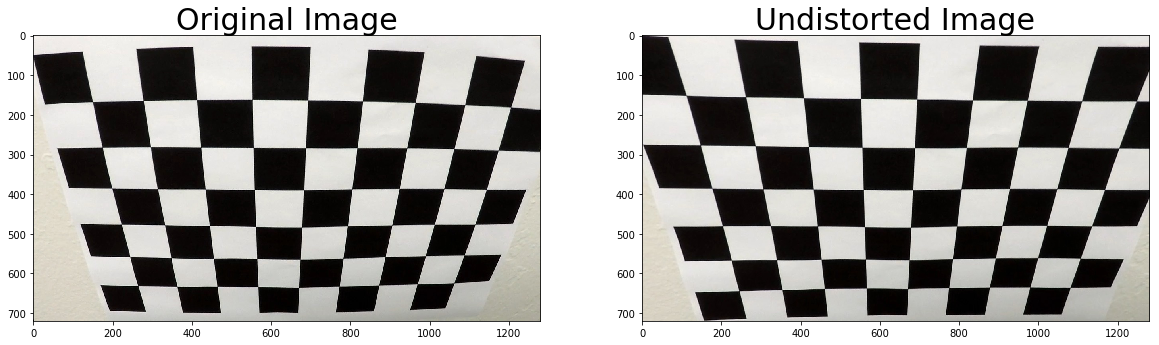

In [4]:
#Test out undistortion
img = mpimg.imread('camera_cal/calibration2.jpg')

dst = undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
def sobel_thresh(img, orient='x', tmin=0, tmax=255, sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= tmin) & (scaled_sobel <= tmax)] = 1    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sy = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    sxy_scaled = np.uint8(255 * sxy / np.max(sxy))
    binary_output = np.zeros_like(sxy_scaled)
    binary_output[(sxy_scaled >= mag_thresh[0]) & (sxy_scaled <= mag_thresh[1])] = 1
    return binary_output
 
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely, sobelx)
    
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    return binary_output

def apply_color_thresh(img, low, high):
    return cv2.inRange(img, low, high)

def apply_thresh(img, thresh = (0, 255)):
    result = np.zeros_like(img)
    result[(img > thresh[0]) & (img <= thresh[1])] = 1

In [6]:
def find_lanes(img): 
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    output_img = np.dstack((img, img, img)) * 255
    midpoint = img.shape[1]//2

    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 10
    window_height = img.shape[0]//nwindows

    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    leftx_current =  leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1) * window_height
        win_y_high = img.shape[0] - window * window_height
    
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        cv2.rectangle(output_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(output_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return [leftx, lefty], [rightx, righty]

def fit_lines(left, right):
    left_fit = np.polyfit(left[1], left[0], 2)
    right_fit = np.polyfit(right[1], right[0], 2)
    return left_fit, right_fit

def lane_curvature(left, right):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/800

    y_eval = 720

    left_fit_cr = np.polyfit(left[1]*ym_per_pix, left[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right[1]*ym_per_pix, right[0]*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return "Curvature %fm %fm" %(left_curverad, right_curverad)
    
def plot_lane(left_fit, right_fit, img):
    output_img = np.zeros_like(img)

    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])

    lane_pts = np.hstack((lane_window1, lane_window2))

    cv2.fillPoly(output_img, np.int_([lane_pts]), (0,255, 0))

    result = cv2.addWeighted(img, 1, output_img, 0.3, 0)

    return result

def unwarp_and_add(img, img2, M):
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, M, img_size, flags = cv2.WARP_INVERSE_MAP)
    unwarped_gray = cv2.cvtColor(unwarped, cv2.COLOR_RGB2GRAY)
    unwarped_mask = np.zeros_like(unwarped_gray)
    unwarped_mask[unwarped_gray == 0] = 1
    src2 = np.dstack([unwarped_mask, unwarped_mask, unwarped_mask]) * 255

    result1 = cv2.bitwise_and(img2, src2)
    result2 = cv2.addWeighted(result1, 1, unwarped, 1, 0)
    return result2

def car_offset(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = img.shape[1]//2
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    lane_center = (leftx_base + rightx_base) // 2
    px_2_m = 3.7 / (rightx_base - leftx_base)
    
    if lane_center < 1280//2:
        return "Offset %f" %((640 - lane_center)*px_2_m)
    elif lane_center > 1280//2:
        return "Offset %f" %((lane_center - 640)*px_2_m)

In [7]:
#pipeline

def run_pipeline(img, video = 1):
    #undistoirt and perspective xfrm
    undist = undistort(img, params['mtx'], params['dist'])
    
    warped, M = perspective_trans(undist)

    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    
    # Find lane lines from R channel
    R = warped[:,:,0]
    bin_R = apply_thresh(R, (200, 255))

    H = hls[:,:,0]
    bin_H = apply_thresh(H, (15, 100))
    
    S = hls[:,:,2]
    bin_S = apply_thresh(S, (90, 255))

    yellow_bin = cv2.inRange(hls, np.array([15, 100, 150]), np.array([35, 200, 255]))
    white_bin = cv2.inRange(hls, np.array([0, 200, 0]), np.array([255, 255, 255]))
    
    lines_img = np.zeros_like(gray)
    #lines_img[((sobel_x == 1) | (sobel_y == 1)) | (binary_S == 1 | (white_bin != 0) | (yellow_bin != 0))] = 1
    lines_img[(white_bin != 0) | (yellow_bin != 0)] = 1
    
    left_pts, right_pts = find_lanes(lines_img)
    left_fit, right_fit = fit_lines(left_pts, right_pts)
    str_off = car_offset(lines_img)
    str_lc = lane_curvature(left_pts, right_pts)
    
    if(video):
        params['lf'][0] = 0.9 * params['lf'][0] + 0.1 * left_fit[0]
        params['lf'][1] = 0.9 * params['lf'][1] + 0.1 * left_fit[1]
        params['lf'][2] = 0.9 * params['lf'][2] + 0.1 * left_fit[2]
        params['rf'][0] = 0.9 * params['rf'][0] + 0.1 * right_fit[0]
        params['rf'][1] = 0.9 * params['rf'][1] + 0.1 * right_fit[1]
        params['rf'][2] = 0.9 * params['rf'][2] + 0.1 * right_fit[2]
        
        left_fit[0] = params['lf'][0] / (1 - 0.9**params['itr'])
        left_fit[1] = params['lf'][1] / (1 - 0.9**params['itr'])
        left_fit[2] = params['lf'][2] / (1 - 0.9**params['itr'])
        right_fit[0] = params['rf'][0] / (1 - 0.9**params['itr'])
        right_fit[1] = params['rf'][1] / (1 - 0.9**params['itr'])
        right_fit[2] = params['rf'][2] / (1 - 0.9**params['itr'])

        params['itr'] += 1
    
    lane_img = plot_lane(left_fit, right_fit, warped)
    result = unwarp_and_add(lane_img, undist, M)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    cv2.putText(result, str_lc, (20, 30), font, fontScale, fontColor, lineType)
    cv2.putText(result, str_off, (20, 60), font, fontScale, fontColor, lineType)
        
    return result

In [8]:
test_images = glob.glob('test_images/*.jpg')

for i, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    
    result = run_pipeline(img, 0)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

    cv2.imshow('img', result)
    cv2.waitKey(500)
    
cv2.destroyAllWindows()

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_output = 'output.mp4'
params['itr'] = 1
params['lf'] = [0, 0, 0]
params['rf'] = [0, 0, 0]

clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(run_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:54<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 3min 56s


In [ ]:
HTML("""
<video width="1280" height="" controls>
  <source src="{0}">
</video>
""".format(lane_clip))